In [1]:
import ast
import numpy as np
import torch
import matplotlib.pyplot as plt

from modules.data_utils import H5LazyDataset

In [2]:
FS: float = 100_000_000

In [3]:
h5_lazy_dataset = H5LazyDataset(
    'data/test/test_public.h5', 'waveforms',
    data_transforms=(
        torch.tensor,
    ),
    label_transforms=(
        lambda _bytes: _bytes.decode('utf-8'),
        ast.literal_eval,
        torch.tensor,
    ),
)

In [4]:
waveform: torch.Tensor
label: torch.Tensor
waveform, label = h5_lazy_dataset[23]

In [5]:
fft_waveform: np.ndarray = np.fft.fft(waveform)
fft_magnitude: np.ndarray = np.abs(fft_waveform)
freqs: np.ndarray = np.fft.fftfreq(len(waveform), d=1/FS)

In [6]:
fft_waveform_shifted: np.ndarray = np.fft.fftshift(fft_waveform)
fft_magnitude_shifted: np.ndarray = np.fft.fftshift(fft_magnitude)
freqs_shifted: np.ndarray = np.fft.fftshift(freqs)

In [7]:
center_freq: float = 2450e6
absolute_freqs = freqs_shifted + center_freq

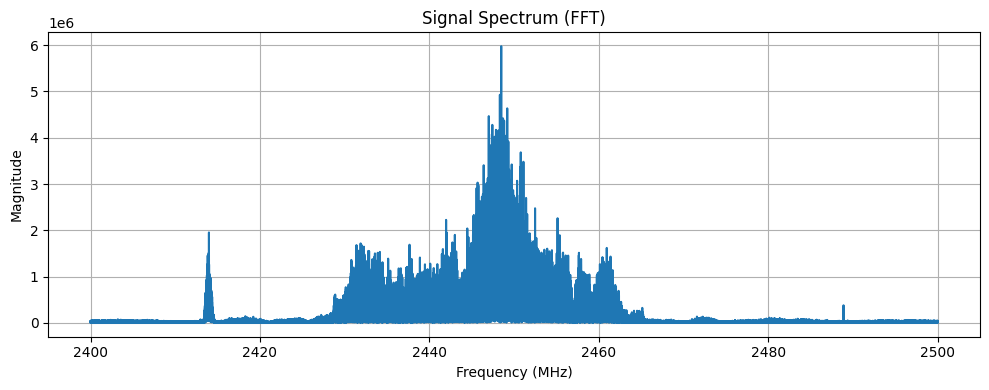

In [8]:
plt.figure(figsize=(10, 4))
plt.plot(absolute_freqs / 1e6, fft_magnitude_shifted)
plt.title("Signal Spectrum (FFT)")
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
print(label)

None
